In [109]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score

## The essence of the hidden layer

We know two things:

* Neural networks are basically logistic regression.
* Gradient descent can get us real far.

Here's an idea just crazy enough it might work:

* What if we do logistic regression in order to classify our samples as some _latent things_.
* And then we do logistic regression using the _latent things_ as features.

For example:

* Take the Fantasy Uber Churn dataset
* Predict if each sample is
 * A business traveler
 * A casual traveler
 * A real jerk
 * A late night party animal
 * Any number of other personas
* Once we've established which categories they belong in, use that to predict if they'll churn.

To discover this "hidden layer" of personas, we'll just initalize feature->persona and persona->churn connections at random, and use the gradient of the loss to slowly move the weights to improve the final loss.

Hopefull, this will result in the discovery of the intermediate hidden layer.


In [4]:
df = pd.read_csv("churn.csv", parse_dates=["last_trip_date","signup_date"])

In [5]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [6]:
today = df.last_trip_date.max()

In [7]:
city_dummies = pd.get_dummies(df.pop("city"))
phone_dummies = pd.get_dummies(df.pop("phone"))
df["signup_dow"] = df.signup_date.dt.weekday
df["age"] = (today - df.signup_date).dt.days
df["pass_rating_blank"] = df.avg_rating_by_driver.isna()
df["driver_rating_blank"] = df.avg_rating_of_driver.isna()
df["avg_rating_by_driver"] = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df["avg_rating_of_driver"] = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

In [8]:
y = (df.last_trip_date <= today-timedelta(days=30)).astype(float).values
y = np.expand_dims(y, axis=1)

In [9]:
df = df.drop(["last_trip_date","signup_date"], axis=1)

In [10]:
X = df.values.astype(float)

In [11]:
np.random.seed(42)

#parameters for hidden layer
W_hidden = tf.Variable(np.random.normal(size=(12,6)))
b_hidden = tf.Variable(np.zeros(shape=(6)))

#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(6,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [12]:
def model(X, W_hidden, b_hidden, W_final, b_final):
    #find activation of hidden layer
    hidden_activation = tf.math.sigmoid( X @ W_hidden + b_hidden )

    #find prediction
    return tf.math.sigmoid( hidden_activation@W_final + b_final )

In [13]:
def getloss(y, yhat):
    return tf.reduce_sum( tf.keras.backend.binary_crossentropy(y, yhat) )

In [14]:
yhat = model(X, W_hidden, b_hidden, W_final, b_final)
getloss(y, yhat)

<tf.Tensor: id=60, shape=(), dtype=float64, numpy=71160.2542384141>

In [15]:
with tf.GradientTape() as t:
    t.watch(W_hidden)
    
    yhat = model(X, W_hidden, b_hidden, W_final, b_final)
    loss = getloss(y, yhat)
    
dloss_dWhidden = t.gradient(loss, W_hidden).numpy()

In [16]:
dloss_dWhidden[:,3]

array([ 2.42173391e+01,  9.14538269e+00,  8.48521514e+00,  3.04829406e+00,
        1.52748636e+02, -1.60464601e-01,  7.96605488e-01, -5.62412772e-01,
        6.50498509e+00,  2.98758180e+02, -3.09842817e-03,  4.19603912e-01])

In [80]:
np.random.seed(42)

#parameters for hidden layer
W_hidden = tf.Variable(np.random.normal(size=(12,6)))
b_hidden = tf.Variable(np.zeros(shape=(6)))

#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(6,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [81]:
def foo():
    return getloss(y, model(X, W_hidden, b_hidden, W_final, b_final))

In [82]:
foo()

<tf.Tensor: id=1526569, shape=(), dtype=float64, numpy=71160.2542384141>

In [83]:
trace = []

In [87]:
optimizer = tf.optimizers.RMSprop()

for i in range(1000):
    optimizer.minimize(foo, [W_hidden, b_hidden, W_final, b_final])
    currloss = foo().numpy()
    print( i, currloss )
    trace.append(currloss)

0 30041.593173259258
1 30008.471300246303
2 30005.974599226873
3 30004.572473994034
4 30003.287786731504
5 30002.072276729486
6 30000.90677385978
7 29999.7785026681
8 29998.678635626093
9 29997.600665776896
10 29996.53967024985
11 29995.491801550023
12 29994.45399931803
13 29993.423779094832
14 29992.399101350995
15 29991.378268019704
16 29990.359857579504
17 29989.34266775255
18 29988.325683277788
19 29987.308039276926
20 29986.28900933235
21 29985.26797490291
22 29984.244435040335
23 29983.217977567187
24 29982.188401175154
25 29981.156243708025
26 29980.12763716926
27 29979.15727249434
28 29978.732422897723
29 29981.675342083927
30 29985.061144678173
31 29980.046779991564
32 29975.220528005262
33 29973.8312150897
34 29972.78118567254
35 29971.83672396354
36 29970.91746430155
37 29970.005328012518
38 29969.094646277423
39 29968.18446057198
40 29967.27802722322
41 29966.385562628464
42 29965.533570370906
43 29964.808611192617
44 29964.397003201404
45 29964.739482352554
46 29965.033285

369 29718.56203867335
370 29717.817374058075
371 29717.281075151623
372 29716.537972460275
373 29716.00331255651
374 29715.26180722889
375 29714.728815069626
376 29713.988942906974
377 29713.457647478626
378 29712.71944284247
379 29712.189871522947
380 29711.45336551193
381 29710.925542165445
382 29710.19076077448
383 29709.664703817092
384 29708.93166611188
385 29708.407386602412
386 29707.676102971447
387 29707.153602813476
388 29706.42407339198
389 29705.90334376204
390 29705.17555714774
391 29704.656577293128
392 29703.93050970125
393 29703.41324627133
394 29702.68886129476
395 29702.173268388622
396 29701.450517544665
397 29700.936537661844
398 29700.215361907598
399 29699.702927980914
400 29698.983260363166
401 29698.472299019224
402 29697.75406858635
403 29697.244504719318
404 29696.527641749308
405 29696.019404400842
406 29695.30384689311
407 29694.796876296467
408 29694.082577524034
409 29693.5768330056
410 29692.863769736236
411 29692.359237969125
412 29691.647418752837
413 2

732 29537.734044490346
733 29537.42188078017
734 29536.902000757807
735 29536.590416680025
736 29536.07116441981
737 29535.76019816012
738 29535.241614043545
739 29534.931306383864
740 29534.413433821715
741 29534.10382768702
742 29533.586712568474
743 29533.27785251389
744 29532.761542579778
745 29532.453474224887
746 29531.938018377325
747 29531.63078779804
748 29531.11623536229
749 29530.809888452502
750 29530.296288408994
751 29529.990870226407
752 29529.478270433483
753 29529.17382454361
754 29528.66227096801
755 29528.358838800577
756 29527.84837477126
757 29527.545994999207
758 29527.036660497943
759 29526.73536844871
760 29526.22719944902
761 29525.927026557678
762 29525.420054422313
763 29525.12102773328
764 29524.615278679274
765 29524.31742040549
766 29523.812915043593
767 29523.51624218886
768 29523.012995141857
769 29522.71751919134
770 29522.215538794648
771 29521.921265478293
772 29521.4205535648
773 29521.12748269742
774 29520.628034469504
775 29520.336159872913
776 295

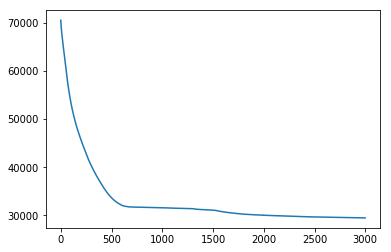

In [88]:
plt.plot(trace)

In [96]:
yhat = model(X, W_hidden, b_hidden, W_final, b_final).numpy().flatten()

In [110]:
roc_auc_score(y.flatten(), yhat)

0.6931322276718463

In [116]:
activations = tf.math.sigmoid( X @ W_hidden + b_hidden ).numpy()

In [142]:
# only columns with index 3 and 4 have any variance

In [157]:
neuron_1 = (activations[:,3]>0.5)
neuron_2 = (activations[:,4]>0.5)

In [171]:
df[neuron_1].mean()

avg_dist                    7.123171
avg_rating_by_driver        4.806855
avg_rating_of_driver        4.616371
avg_surge                   1.111759
surge_pct                  12.857591
trips_in_first_30_days      1.012661
luxury_car_user             0.310924
weekday_pct                92.431417
signup_dow                  2.889453
age                       164.737941
pass_rating_blank           0.006644
driver_rating_blank         0.252276
dtype: float64

In [168]:
df[neuron_2].mean()

avg_dist                    6.116270
avg_rating_by_driver        4.771641
avg_rating_of_driver        4.593224
avg_surge                   1.000000
surge_pct                   0.000000
trips_in_first_30_days      0.907870
luxury_car_user             0.247033
weekday_pct                 0.000625
signup_dow                  4.210493
age                       165.807152
pass_rating_blank           0.007964
driver_rating_blank         0.331355
dtype: float64

In [172]:
df[neuron_1].mean() - df[neuron_2].mean()

avg_dist                   1.006901
avg_rating_by_driver       0.035214
avg_rating_of_driver       0.023147
avg_surge                  0.111759
surge_pct                 12.857591
trips_in_first_30_days     0.104791
luxury_car_user            0.063891
weekday_pct               92.430792
signup_dow                -1.321041
age                       -1.069211
pass_rating_blank         -0.001319
driver_rating_blank       -0.079080
dtype: float64

Neuron 1 activates when a passenger takes surge ride and rides on the weekdays. Neuron 2 activates when the passenger rides less and only on the weekends. For about half of passengers, neither neuron activates.

In [217]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(6, activation="sigmoid"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

def cross_entropy(y, yhat):
    return tf.reduce_sum(-(y*tf.math.log(yhat)+(1-y)*tf.math.log(1-yhat)))

model.compile(optimizer='adam',
              loss=cross_entropy)

hist = model.fit(X,y, epochs=1000, batch_size=1024)

Epoch 1/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 674.7974
Epoch 2/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 659.0413
Epoch 3/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 654.5189
Epoch 4/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 652.6453
Epoch 5/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 651.3531
Epoch 6/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 649.8944
Epoch 7/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 643.0210
Epoch 8/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 627.2972
Epoch 9/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 622.4288
Epoch 10/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 618.7809
Epoch 11/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 616.05

50000/50000 [==============================] - 0s 4us/sample - loss: 571.7342
Epoch 91/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 571.2355
Epoch 92/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 571.0434
Epoch 93/1000
50000/50000 [==============================] - 0s 6us/sample - loss: 570.8764
Epoch 94/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 571.0284
Epoch 95/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 570.7388
Epoch 96/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 570.5876
Epoch 97/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 570.0987
Epoch 98/1000
50000/50000 [==============================] - 0s 5us/sample - loss: 569.9246
Epoch 99/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 569.8619
Epoch 100/1000
50000/50000 [==============================] - 0s 4us/sample - loss: 569.9987
E

50000/50000 [==============================] - 0s 3us/sample - loss: 558.4937
Epoch 179/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.7276
Epoch 180/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.5943
Epoch 181/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.5137
Epoch 182/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.6946
Epoch 183/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.5688
Epoch 184/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.3077
Epoch 185/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.4084
Epoch 186/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.3411
Epoch 187/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 558.4471
Epoch 188/1000
50000/50000 [==============================] - 0s 3us/sample - loss: 5

KeyboardInterrupt: 

In [218]:
yhat = (model.predict(X)>0.5).ravel()

In [219]:
roc_auc_score(y, yhat)

0.6819549934088062

In [237]:
W, b = model.layers[0].weights

In [238]:
hidden_activations = (tf.sigmoid( X @ W + b )>0.5).numpy()

In [256]:
df[ hidden_activations.T[0] ].mean()

avg_dist                    5.808791
avg_rating_by_driver        4.777735
avg_rating_of_driver        4.601857
avg_surge                   1.070598
surge_pct                   8.356494
trips_in_first_30_days      2.290342
luxury_car_user             0.377933
weekday_pct                61.130299
signup_dow                  3.303955
age                       165.482375
pass_rating_blank           0.003901
driver_rating_blank         0.160785
dtype: float64

In [270]:
# and so forth